#Report - Sentiment Analysis Using Machine Learning Models



In [3]:

# Importing Libraries
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from transformers import AutoModelForSequenceClassification
from datasets import load_metric
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from string import punctuation
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.tree import DecisionTreeClassifier
from matplotlib.pyplot import figure
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer  
from wordcloud import WordCloud, STOPWORDS
import emoji

import regex
from NLP import NLP

from collections import Counter


In [4]:
# Reading the  data using Pandas Data Frame
tweets_hashtag=pd.read_csv('Data\Tesla_Final\Hashtag Tesla Tweets.csv')
youtube_df=pd.read_csv('Data\Youtube_Final\youtube_comments_2.csv')

In [5]:
# Converting Date time columns into date time format
tweets_hashtag['Date & Time']=pd.to_datetime(tweets_hashtag['Date & Time'])


In [6]:
# Fittering the data for before and after the incident
tweets_loc=(tweets_hashtag['Date & Time']>'2022-07-20 00:11:00') & (tweets_hashtag['Date & Time']<'2022-10-15 00:00:00')
tweets_df=tweets_hashtag.loc[tweets_loc]
tweets_df.shape

(61938, 5)

Data Understanding

In [7]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61938 entries, 69777 to 131714
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date & Time           61938 non-null  datetime64[ns]
 1   Profile Picture Link  61938 non-null  object        
 2   Twitter ID            61938 non-null  object        
 3   Tweet Text            61938 non-null  object        
 4   Tweet Link            61938 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 2.8+ MB


In [ ]:
tweets_df.describe().T

In [9]:
tweets_df=tweets_df.rename({'Tweet Text':'tweet_text'},axis=1)

In [10]:
# Fitlering the tweet text columns
tweets_eda=pd.DataFrame()
tweets_eda['Num_words'] = tweets_df['tweet_text'].apply(lambda x:len(str(x).split()))
tweets_eda['words'] = tweets_df['tweet_text'].apply(lambda x:str(x).split())
tweets_eda.head()

,Num_words,words
69777,15,"[RT, @M3Marcel:, 2nd, Carwash, with, the, Perf..."
69778,29,"[RT, @RobJohnsonShred:, ✅🚀🔹🔹, ALGORAND, #algo,..."
69779,25,"[RT, @RobJohnsonShred:, 🚀✅🔺, AVALANCHE, #AVAX,..."
69780,9,"[RT, @uncutdopeness:, 2, million, cars, #Tesla..."
69781,15,"[RT, @M3Marcel:, 2nd, Carwash, with, the, Perf..."


In [ ]:
# Checking the distribution of number of words in a tweets
sns.set(rc={"figure.figsize": (8, 4)}); np.random.seed(0)
x = np.random.randn(100)
ax = sns.distplot(tweets_eda['Num_words'])
plt.show()

In [12]:
#Dropping the unused columns 
#drop_col=['Screen_name','Date','Source','Link']
drop_col=['Date & Time', 'Profile Picture Link', 'Twitter ID', 'Tweet Link']
tweets_df=tweets_df.drop(drop_col,axis=1)

Extracting & Decoding Emojis

In [13]:
# Function to decode the emoji using EmoJI library

def emoji_trimmer(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    #print(data)
    
    for tex in data:
        #print(tex)
        if any(char in emoji.EMOJI_UNICODE_ENGLISH for char in tex):
            #print(tex)
            emoji_list.append(tex)
            #print("inside if")
            #print(emoji_list)
    return emoji_list

In [ ]:
# After decoding now we have to extract the Emoji's.
Tobeclean_emojilist1=[]
for ind in tweets_df.index:
    val1=tweets_df['tweet_text'][ind]
    counter = emoji_trimmer(val1)
    a=(' '.join(emoji for emoji in counter))
    Tobeclean_emojilist1.append(a)

In [15]:
# Creating the emoji list
onlyemojis=[]
for ind in tweets_df.index:
    val1=tweets_df['tweet_text'][ind]
    emdistint=emoji.distinct_emoji_list(val1)
    a=(' '.join(emoji for emoji in emdistint))
    onlyemojis.append(a)


In [16]:
onlyemojis[:10]

['\U0001f979',
 '🚀 ✅ 🔹',
 '🚀 🔺 ✅',
 '',
 '\U0001f979',
 '',
 '🇨🇳 🇪🇺 🇸🇬',
 '🇺🇸 💪🏻',
 '',
 '🔋 🔌 🚙']

In [17]:
# Extracting the unicode from emojis
emoji_append=[]
def extract_unicode(l):  
    for i in l:
        try:
            #print("inside i")
            val1=f"0x{ord(i):08x}"
            emoji_append.append(val1)
        except:
            val1 = i.encode('unicode-escape')
            emoji_append.append(val1)
    return emoji_append

In [18]:
unicode_emoji=extract_unicode(onlyemojis)

In [19]:
# Adding Emojis and Unicodes that are extracted against each tweet to existing dataframe
tweets_df['Emoji']=onlyemojis
tweets_df['Unicode']=unicode_emoji

In [20]:
tweets_df.head()

,tweet_text,Emoji,Unicode
69777,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979
69778,RT @RobJohnsonShred: ✅🚀🔹🔹 ALGORAND #algo #Algo...,🚀 ✅ 🔹,b'\\U0001f680 \\u2705 \\U0001f539'
69779,RT @RobJohnsonShred: 🚀✅🔺 AVALANCHE #AVAX #Ava...,🚀 🔺 ✅,b'\\U0001f680 \\U0001f53a \\u2705'
69780,RT @uncutdopeness: 2 million cars #Tesla #Frem...,,b''
69781,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979


In [21]:
# Creating a separating unicode for each emoji
split_emoji_list=[]
for s in tweets_df['Unicode']:
   # print(s)
    emoji_split = str(s).rsplit(" ")
    split_emoji_list.append(emoji_split)

In [22]:
tweets_df['Split_Unicode'] = split_emoji_list

In [23]:
tweets_df.head()

,tweet_text,Emoji,Unicode,Split_Unicode
69777,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979,[0x0001f979]
69778,RT @RobJohnsonShred: ✅🚀🔹🔹 ALGORAND #algo #Algo...,🚀 ✅ 🔹,b'\\U0001f680 \\u2705 \\U0001f539',"[b'\\U0001f680, \\u2705, \\U0001f539']"
69779,RT @RobJohnsonShred: 🚀✅🔺 AVALANCHE #AVAX #Ava...,🚀 🔺 ✅,b'\\U0001f680 \\U0001f53a \\u2705',"[b'\\U0001f680, \\U0001f53a, \\u2705']"
69780,RT @uncutdopeness: 2 million cars #Tesla #Frem...,,b'',[b'']
69781,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979,[0x0001f979]


In [24]:
#Final method to perform string operation on emoji unicodes
def clean_unicode(value):
    split_list = []
    findb=str(value).find("b''")
    find01=str(value).find("\\\\U000")
    findb1=str(value).find("b'")
    findu=str(value).find("\\u")
    findexl=str(value).find("'")
    findslash=str(value).find("\ ")
    findxoo=str(value).find("[0x000")
    findsqrbrac=str(value).find("]")
    findslashxoo=str(value).find("['0x000")
    findslashxoo1=str(value).find("['0x0000")
    findslashxoo2=str(value).find("0x000")
    if findb !=-1 or find01!=-1 or findu !=-1 or findb1!=-1 or findexl!=-1 or findslash!=-1 or findxoo!=-1 or findsqrbrac!=-1 or findslashxoo2!=-1:
        replacedb=str(value).replace("b''","")
        replacedb=str(value).replace("b'","")
        #print("1",replacedb)
        replacedb=replacedb.replace("\\\\U000"," ")
        replacedb=replacedb.replace("\\u"," ")
        replacedb=replacedb.replace("'"," ")
        replacedb=replacedb.replace("\ "," ")
        replacedb=replacedb.replace("0x000","")#added-200821
        replacedb=replacedb.replace("[0x000","")
        replacedb=replacedb.replace("['0x000"," ") #added-200821
        replacedb=replacedb.replace("['0x0000"," ")#added-200821
        replacedb=replacedb.replace("\\"," ") #added
        replacedb=replacedb.replace("U000","") #added
        replacedb=replacedb.replace("b'","") #added
        replacedb=replacedb.replace("[","")
        replacedb=replacedb.replace("]","")
        replacedb=replacedb.replace("']"," ")#added-200821
        split_list.append(replacedb)
       # print()
    return split_list

In [25]:
#Creating a column in dataframe to hold the cleaned unicode values
tweets_df.insert(loc=4,column='Cleaned_Unicode',value="")

In [26]:
#method to update dataframe with cleaned unicode which is from the output of method "Split_unicode"
for ind in tweets_df.index:
    replacedba=[]
    val1= tweets_df['Split_Unicode'][ind]
    #print("val1",val1)
    for value in val1:
        #print("value",value)
        counter = clean_unicode(value)
        #print("counter",counter)
        a=(' '.join(emoji for emoji in counter))
        replacedba.append(a)
        #print("replacedba",replacedba)
        tweets_df.at[ind , 'Cleaned_Unicode'] = replacedba

In [27]:
tweets_df.head()

,tweet_text,Emoji,Unicode,Split_Unicode,Cleaned_Unicode
69777,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979,[0x0001f979],[1f979]
69778,RT @RobJohnsonShred: ✅🚀🔹🔹 ALGORAND #algo #Algo...,🚀 ✅ 🔹,b'\\U0001f680 \\u2705 \\U0001f539',"[b'\\U0001f680, \\u2705, \\U0001f539']","[ 1f680, 2705, 1f539 ]"
69779,RT @RobJohnsonShred: 🚀✅🔺 AVALANCHE #AVAX #Ava...,🚀 🔺 ✅,b'\\U0001f680 \\U0001f53a \\u2705',"[b'\\U0001f680, \\U0001f53a, \\u2705']","[ 1f680, 1f53a, 2705 ]"
69780,RT @uncutdopeness: 2 million cars #Tesla #Frem...,,b'',[b''],[ ]
69781,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979,[0x0001f979],[1f979]


In [28]:
#Updating the blank cells with Nan in the dataframe
tweets_df.replace('', np.nan, inplace=True) 

Text Preprocessing

In [29]:
# Before Assigning the polarity to the text we'll clean the data removing hashtags, url's ,punctuations etc

def clear(text, regulexp):
    r = re.findall(regulexp, text)
    for i in r:
        text = re.sub(i, '', text)
    return text

tweets_df['clean_tweet'] = np.vectorize(clear)(tweets_df['tweet_text'], "@[\w]*") 
tweets_df.head(5)

,tweet_text,Emoji,Unicode,Split_Unicode,Cleaned_Unicode,clean_tweet
69777,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979,[0x0001f979],[1f979],RT : 2nd Carwash with the Performance - high q...
69778,RT @RobJohnsonShred: ✅🚀🔹🔹 ALGORAND #algo #Algo...,🚀 ✅ 🔹,b'\\U0001f680 \\u2705 \\U0001f539',"[b'\\U0001f680, \\u2705, \\U0001f539']","[ 1f680, 2705, 1f539 ]",RT : ✅🚀🔹🔹 ALGORAND #algo #Algorand #altcoins #...
69779,RT @RobJohnsonShred: 🚀✅🔺 AVALANCHE #AVAX #Ava...,🚀 🔺 ✅,b'\\U0001f680 \\U0001f53a \\u2705',"[b'\\U0001f680, \\U0001f53a, \\u2705']","[ 1f680, 1f53a, 2705 ]",RT : 🚀✅🔺 AVALANCHE #AVAX #Avalanche #Elonmusk...
69780,RT @uncutdopeness: 2 million cars #Tesla #Frem...,NaN,b'',[b''],[ ],RT : 2 million cars #Tesla #Fremont #Tsla http...
69781,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979,[0x0001f979],[1f979],RT : 2nd Carwash with the Performance - high q...


In [30]:
tweets_df.iloc[0]['clean_tweet']

'RT : 2nd Carwash with the Performance - high quality wing\U0001f979 #tesla \n  https://t.co/hXU3Mi1HiV'

In [31]:

tweets_df['clean_tweet'] = tweets_df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
tweets_df['clean_tweet'] = tweets_df['clean_tweet'].str.replace("RT", " ")


C:\Users\PraVeeN\AppData\Local\Temp\ipykernel_29876\1471868880.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['clean_tweet'] = tweets_df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")


In [32]:
# Removing Punctuations & Unnecessary words
import string
def text_clean(text):
    text=text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
clean_data=[]
for i in tweets_df['clean_tweet']:
    clean_data.append(text_clean(i))


In [33]:
tweets_df['clean_tweet1']=clean_data

In [34]:
tweets_df['clean_tweet1'] = tweets_df['clean_tweet1'].str.replace("rt", " ")

In [35]:
tweets_df.head()

,tweet_text,Emoji,Unicode,Split_Unicode,Cleaned_Unicode,clean_tweet,clean_tweet1
69777,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979,[0x0001f979],[1f979],nd Carwash with the Performance high qu...,nd carwash with the performance high qu...
69778,RT @RobJohnsonShred: ✅🚀🔹🔹 ALGORAND #algo #Algo...,🚀 ✅ 🔹,b'\\U0001f680 \\u2705 \\U0001f539',"[b'\\U0001f680, \\u2705, \\U0001f539']","[ 1f680, 2705, 1f539 ]",ALGORAND #algo #Algorand #altcoins #a...,algorand algo algorand altcoins altco...
69779,RT @RobJohnsonShred: 🚀✅🔺 AVALANCHE #AVAX #Ava...,🚀 🔺 ✅,b'\\U0001f680 \\U0001f53a \\u2705',"[b'\\U0001f680, \\U0001f53a, \\u2705']","[ 1f680, 1f53a, 2705 ]",AVALANCHE #AVAX #Avalanche #Elonmusk ...,avalanche avax avalanche elonmusk tes...
69780,RT @uncutdopeness: 2 million cars #Tesla #Frem...,NaN,b'',[b''],[ ],million cars #Tesla #Fremont #Tsla https...,million cars tesla fremont tsla https ...
69781,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979,[0x0001f979],[1f979],nd Carwash with the Performance high qu...,nd carwash with the performance high qu...


Polarity Assignment

In [36]:
# Assigning the polarity to the cleaned tweets data using Text Blob

result = []
pola = []
#for value in data["Tweet"]:
for value in tweets_df["clean_tweet1"]:
    pola1=TextBlob(value).polarity
    #print("polaa",pola)
    if pola1 >0 :
        result.append("Positive")
        pola.append(pola1)
    elif pola1 < 0 :
        result.append("Negative")
        pola.append(pola1)
    else:
        result.append("Neutral")
        pola.append(pola1)
#data["Result"] = result
#data["Senti"] = pola
tweets_df["Text_senti"] = result
tweets_df["Text_senti_score"] = pola

<AxesSubplot: xlabel='Text_senti', ylabel='count'>

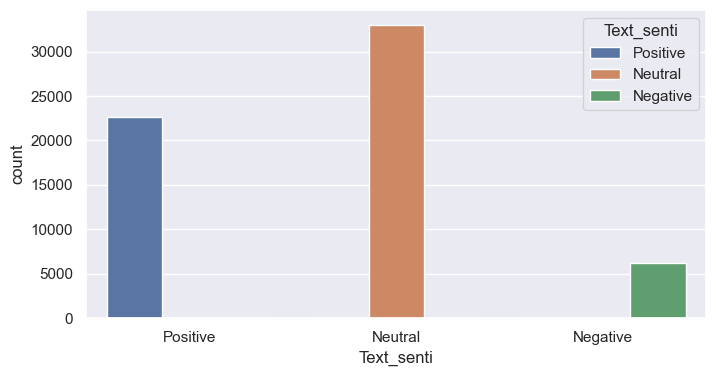

In [37]:
# Checking the distribution of target variable , there is class imbalance
sns.countplot(x='Text_senti',data=tweets_df,hue="Text_senti") 

In [38]:
#Emoji + Textblob

#Removing the tweets whihc doesn't have emojis
cleaned_emojilist1=[]
for i in tweets_df["Cleaned_Unicode"]:
    if i!=[' '] and i!=['']:
        cleaned_emojilist1.append(i)

In [39]:
#Converting cleaned_emojilist1 to a single list to find the unique emoji list
unique_list=[]
for i in cleaned_emojilist1:
    for j in i:
        j=j.rstrip()
        unique_list.append(j)   

In [52]:
# Creating a dataframe to assign the polarity 
# Creating a dataframe to assign the polarity 
unique_list=set(unique_list)
df_emoji_rank1 =pd.DataFrame (unique_list,columns=['Emojis'])
df_emoji_rank=pd.concat([df_emoji_rank1,pd.DataFrame(columns=['Positive','Negative','Neutral','PPos','PNeg','PNeu'])])

,Emojis,Positive,Negative,Neutral,P-,P+,P0
0,,,,,,,
1,2604 fe0f,,,,,,
2,1f1f7 1f1fa,,,,,,
3,1f451,,,,,,
4,1f338,,,,,,


In [47]:
def retrieve_index(value):
    index=df_emoji_rank[df_emoji_rank['Emojis']==value].index.values
    return index

In [ ]:
# Code to find the match of emoji in score card by looping through data df and retriving the index and matching
# the sentiment and retrieve current value of count and updating the counter within this loop and update the score card value for
# respective emoji

count_pos=count_neg=count_neu=0
for index in tweets_df.index:
    base_emoji= tweets_df['Cleaned_Unicode'][index]
    base_emoji_result=tweets_df['Text_senti'][index]
    counter=1
    while counter<=len(base_emoji):
        if base_emoji != [' '] and base_emoji != [''] :
            for j in base_emoji:
                j=j.rstrip()
                if base_emoji_result=="Positive":
                    pos_ind= retrieve_index(j)
                    new_array = pos_ind.astype(np.int)
                    index_int_pos=new_array[0]
    
                    current_pos=df_emoji_rank.iloc[index_int_pos]['Positive']
                    if current_pos=="":
                        df_emoji_rank.loc[index_int_pos, 'Positive'] = 1
                    else:
                        update_pos=current_pos+1
                    try:
                        df_emoji_rank.loc[index_int_pos, 'Positive'] = update_pos
                        counter=counter+1
                    except:
                        pass
                elif base_emoji_result=="Negative":
                    pos_neg= retrieve_index(j)
                    new_array = pos_neg.astype(np.int)
                    index_int_neg=new_array[0]
                    current_neg=df_emoji_rank.iloc[index_int_neg]['Negative']
                    if current_neg=="":
                        df_emoji_rank.loc[index_int_neg, 'Negative'] = 1
                    else:
                        update_neg=current_neg+1
                    try:
                        df_emoji_rank.loc[index_int_neg, 'Negative'] = update_neg
                        counter=counter+1
                    except:
                        pass
                elif base_emoji_result=="Neutral":
                    neu_ind= retrieve_index(j)
                    new_array = neu_ind.astype(np.int)
                    #print("new",new_array)
                    index_int_neu=new_array[0]
                    current_neu=df_emoji_rank.iloc[index_int_neu]['Neutral']
                    if current_neu=="":
                        df_emoji_rank.loc[index_int_neu, 'Neutral']=1
                    else:
                        update_neu=current_neu+1
                        try:
                            df_emoji_rank.loc[index_int_neu, 'Neutral'] = update_neu
                            counter=counter+1
                        except:
                            pass
        counter=counter+1            


In [49]:
df_emoji_rank.replace('', 0, inplace=True)

In [50]:
column_list=['Positive','Negative','Neutral']
df_emoji_rank["N"] = df_emoji_rank[column_list].sum(axis=1)

In [51]:
df_emoji_rank.head()

,Emojis,Positive,Negative,Neutral,PPos,PNeg,PNeu,N
0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2604 fe0f,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1f1f7 1f1fa,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,1f451,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,1f338,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
df_emoji_rank["P+"]=df_emoji_rank['Positive']/df_emoji_rank['N']
df_emoji_rank["P-"]=df_emoji_rank['Negative']/df_emoji_rank['N']
df_emoji_rank["P0"]=df_emoji_rank['Neutral']/df_emoji_rank['N']

In [ ]:
#sentiment score, s, as the mean of the discrete probability distribution
df_emoji_rank['s']=df_emoji_rank[['P-', 'P+','P0']].mean(axis=1)

In [ ]:
tweets_df['Emoji_Senti']=''
#Method to calulate the emoji score of tweet
for index in tweets_df.index:
    sum_score=[]
    base_list= tweets_df['Cleaned_Unicode'][index]
    if base_list==[' '] or base_list==['']:
        tweets_df['Emoji_Senti'][index]=0   
    else:
        for j in base_list:
            j=j.rstrip()
            emoji_index=retrieve_index(j)
            emoji_new_array = emoji_index.astype(np.int)
            try:
                emoji_index_int=emoji_new_array[0]
            except:
                j=j.lstrip()
                #print("J lstrip",j)
                emoji_index=retrieve_index(j)
                emoji_new_array = emoji_index.astype(np.int)        
            s_score=df_emoji_rank['s'][emoji_index_int]

            sum_score.append(s_score)
            #print(sum_score)
        total_score=sum(sum_score)
        tweets_df['Emoji_Senti'][index]=total_score

In [ ]:
#Final sentiment score of tweet i.e textblob + emoji score =data['SentimenScore']
tweets_df['Overall_Senti_Score']=tweets_df['Text_senti_score']+tweets_df['Emoji_Senti']

In [ ]:
tweets_df['Final_Label']=''
tweets_df['deep_Final_Label']=''
#Method to update the final label
for final_index in tweets_df.index:
    sum_score=[]
    f_base_list= tweets_df['Overall_Senti_Score'][final_index]
    if f_base_list< 0:
        tweets_df['Final_Label'][final_index]="Negative"
        tweets_df['deep_Final_Label'][final_index]=-1
    elif f_base_list>0:
        tweets_df['Final_Label'][final_index]="Positive"
        tweets_df['deep_Final_Label'][final_index]=1
    else :
        tweets_df['Final_Label'][final_index]="Neutral"
        tweets_df['deep_Final_Label'][final_index]=0

In [ ]:
# Demojifying the tweet
def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF" 
        u"\U0001F680-\U0001F6FF" 
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags = re.UNICODE)
    text =regrex_pattern.sub(r'',text)
    
    return text
clean_emojis=[]
for i in tweets_df['clean_tweet1']:
    clean_emojis.append(remove_emoji(i))
tweets_df['clean_tweet1']=clean_emojis

Final Dataset

In [ ]:
tweets_df.head()

,tweet_text,Emoji,Unicode,Split_Unicode,Cleaned_Unicode,clean_tweet,clean_tweet1,Text_senti,Text_senti_score,Emoji_Senti,Overall_Senti_Score,Final_Label,deep_Final_Label
69777,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979,[0x0001f979],[1f979],RT : 2nd Carwash with the Performance - high q...,carwash with the performance high quality...,Positive,0.16,0.333333,0.493333,Positive,1
69778,RT @RobJohnsonShred: ✅🚀🔹🔹 ALGORAND #algo #Algo...,🚀 🔹 ✅,b'\\U0001f680 \\U0001f539 \\u2705',"[b'\\U0001f680, \\U0001f539, \\u2705']","[ 1f680, 1f539, 2705 ]",RT : ✅🚀🔹🔹 ALGORAND #algo #Algorand #altcoins #...,✅ algorand algo algorand altcoins altcoin a...,Neutral,0.00,1.0,1.0,Positive,1
69779,RT @RobJohnsonShred: 🚀✅🔺 AVALANCHE #AVAX #Ava...,🔺 🚀 ✅,b'\\U0001f53a \\U0001f680 \\u2705',"[b'\\U0001f53a, \\U0001f680, \\u2705']","[ 1f53a, 1f680, 2705 ]",RT : 🚀✅🔺 AVALANCHE #AVAX #Avalanche #Elonmusk...,✅ avalanche avax avalanche elonmusk tesla ...,Neutral,0.00,1.0,1.0,Positive,1
69780,RT @uncutdopeness: 2 million cars #Tesla #Frem...,NaN,b'',[b''],[ ],RT : 2 million cars #Tesla #Fremont #Tsla http...,million cars tesla fremont tsla,Neutral,0.00,0,0.0,Neutral,0
69781,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979,[0x0001f979],[1f979],RT : 2nd Carwash with the Performance - high q...,carwash with the performance high quality...,Positive,0.16,0.333333,0.493333,Positive,1


In [ ]:
tweets_df['Text_senti'].value_counts()

Neutral     34384
Positive    21619
Negative     5935
Name: Text_senti, dtype: int64

In [ ]:
tweets_df['Final_Label'].value_counts()

Positive    33329
Neutral     24169
Negative     4440
Name: Final_Label, dtype: int64

<AxesSubplot: xlabel='Final_Label', ylabel='count'>

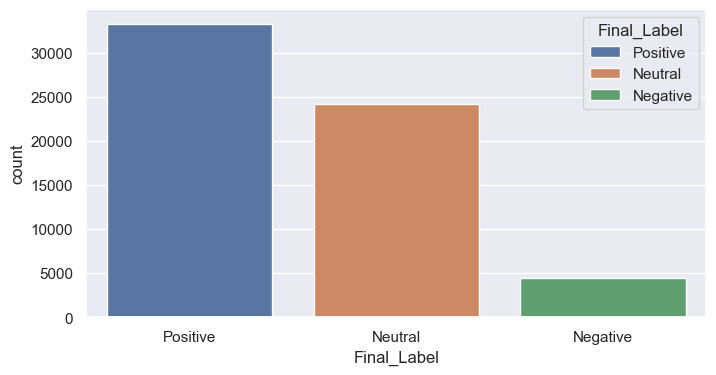

In [ ]:
#plt.figure(figsize=(12,6))
sns.countplot(x='Final_Label',data=tweets_df,hue="Final_Label",dodge=False)

In [ ]:
finaldf=tweets_df.to_csv('Final_df.csv')

In [ ]:
tesla_tweets=pd.read_csv('Final_df.csv')

In [ ]:
tesla_tweets.head()

,Unnamed: 0,tweet_text,Emoji,Unicode,Split_Unicode,Cleaned_Unicode,clean_tweet,clean_tweet1,Text_senti,Text_senti_score,Emoji_Senti,Overall_Senti_Score,Final_Label,deep_Final_Label
0,69777,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979,['0x0001f979'],['1f979'],RT : 2nd Carwash with the Performance - high q...,carwash with the performance high quality...,Positive,0.16,0.333333,0.493333,Positive,1
1,69778,RT @RobJohnsonShred: ✅🚀🔹🔹 ALGORAND #algo #Algo...,🚀 🔹 ✅,b'\\U0001f680 \\U0001f539 \\u2705',"[""b'\\\\U0001f680"", '\\\\U0001f539', ""\\\\u270...","[' 1f680', ' 1f539', ' 2705 ']",RT : ✅🚀🔹🔹 ALGORAND #algo #Algorand #altcoins #...,✅ algorand algo algorand altcoins altcoin a...,Neutral,0.00,1.000000,1.000000,Positive,1
2,69779,RT @RobJohnsonShred: 🚀✅🔺 AVALANCHE #AVAX #Ava...,🔺 🚀 ✅,b'\\U0001f53a \\U0001f680 \\u2705',"[""b'\\\\U0001f53a"", '\\\\U0001f680', ""\\\\u270...","[' 1f53a', ' 1f680', ' 2705 ']",RT : 🚀✅🔺 AVALANCHE #AVAX #Avalanche #Elonmusk...,✅ avalanche avax avalanche elonmusk tesla ...,Neutral,0.00,1.000000,1.000000,Positive,1
3,69780,RT @uncutdopeness: 2 million cars #Tesla #Frem...,NaN,b'',"[""b''""]",[' '],RT : 2 million cars #Tesla #Fremont #Tsla http...,million cars tesla fremont tsla,Neutral,0.00,0.000000,0.000000,Neutral,0
4,69781,RT @M3Marcel: 2nd Carwash with the Performance...,🥹,0x0001f979,['0x0001f979'],['1f979'],RT : 2nd Carwash with the Performance - high q...,carwash with the performance high quality...,Positive,0.16,0.333333,0.493333,Positive,1


In [ ]:
# There is class imbalance and the code is also not eexecuting completely witht this data due to RAM issues. So Reducing the training data.

tesla_tweets_p=tesla_tweets[tesla_tweets.Final_Label == 'Positive'][:4000]
tesla_tweets_n=tesla_tweets[tesla_tweets.Final_Label == 'Neutral'][:4000]
tesla_tweets_Ne=tesla_tweets[tesla_tweets.Final_Label == 'Negative']
tesla_bal=pd.concat([tesla_tweets_p,tesla_tweets_n,tesla_tweets_Ne])

x=tesla_bal['clean_tweet1']
y=tesla_bal['Final_Label']

TFIDF Vectorizer

In [ ]:
tfidfconverter = TfidfVectorizer()
X = tfidfconverter.fit_transform(x.values.astype('U')).toarray()


Train & Test Split

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.25,random_state=12,stratify=y)

Model Building

In [ ]:
model_DT=DecisionTreeClassifier(criterion='entropy')
DT_fit=model_DT.fit(X_train,Y_train)
DT_pred=model_DT.predict(X_test)

In [ ]:
model_DT.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
print("Accuracy using DT Model {}".format(metrics.accuracy_score(Y_test,DT_pred)))
print("Recall Score using DT Model {}".format(metrics.recall_score(Y_test,DT_pred,average='micro')))
print("Precision Score using DT Model {}".format(metrics.precision_score(Y_test,DT_pred,average='micro')))
print("F1 Score using DT Model {}".format(metrics.f1_score(Y_test,DT_pred,average='micro')))
print("Confusion Matrix using DT Model {}".format(metrics.confusion_matrix(Y_test,DT_pred)))

# plot_confusion_matrix(model_DT, X_test, Y_test,cmap=plt.cm.Blues) 
# figure(figsize=(10, 10), dpi=80)
# plt.show() 

Model Building Using SVM model

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train,Y_train)
#model_Evaluate(SVCmodel)
svm_pred = SVCmodel.predict(X_test)
print("Accuracy using SVM Model {}".format(metrics.accuracy_score(Y_test,svm_pred)))
print("Recall Score using SVM Model {}".format(metrics.recall_score(Y_test,svm_pred,average='micro')))
print("Precision Score using SCM Model {}".format(metrics.precision_score(Y_test,svm_pred,average='micro')))
print("F1 Score using SVM Model {}".format(metrics.f1_score(Y_test,svm_pred,average='micro')))
print("Confusion Matrix using SVM Model {}".format(metrics.confusion_matrix(Y_test,svm_pred)))
# plot_confusion_matrix(SVCmodel, X_test, Y_test,cmap=plt.cm.Blues) 
# figure(figsize=(8, 6), dpi=80)
# plt.show() 

In [ ]:
# MultiNominal Naive Bayes
Model_NB = MultinomialNB()
NB_fit=Model_NB.fit(X_train,Y_train)
NB_pred = Model_NB.predict(X_test)
print("Accuracy using NB Model {}".format(metrics.accuracy_score(Y_test,NB_pred)))
print("Recall Score using NB Model {}".format(metrics.recall_score(Y_test,NB_pred,average='micro')))
print("Precision Score using NB Model {}".format(metrics.precision_score(Y_test,NB_pred,average='micro')))
print("F1 Score using NB Model {}".format(metrics.f1_score(Y_test,NB_pred,average='micro')))
print("Confusion Matrix using NB Model {}".format(metrics.confusion_matrix(Y_test,NB_pred)))
# plot_confusion_matrix(Model_NB, X_test, Y_test,cmap=plt.cm.Blues) 
# figure(figsize=(8, 6), dpi=80)
# plt.show() 

In [12]:
tesla_tweets_p1=tesla_tweets[tesla_tweets.Final_Label == 'Positive'][:200]
tesla_tweets_n1=tesla_tweets[tesla_tweets.Final_Label == 'Neutral'][:200]
tesla_tweets_Ne1=tesla_tweets[tesla_tweets.Final_Label == 'Negative'][:200]
tesla_bal1=pd.concat([tesla_tweets_p1,tesla_tweets_n1,tesla_tweets_Ne1])

x1=tesla_bal['clean_tweet1']
y1=tesla_bal['Final_Label']

In [13]:
tfidfconverter1 = TfidfVectorizer()
X1 = tfidfconverter1.fit_transform(x1.values.astype('U')).toarray()
X_train1,X_test1,Y_train1,Y_test1=train_test_split(X1,y1,test_size=0.25,random_state=122,stratify=y1)

In [14]:
# Hyper Parameter Tuning For SVM Algorithm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','Poly']} 
  
grid_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid_svm.fit(X_train1, Y_train1)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


Model Building using Naive Bayes Algorithm

In [ ]:
# MultiNominal Naive Bayes
Model_NB = MultinomialNB()
NB_fit=Model_NB.fit(X_train,Y_train)
NB_pred = Model_NB.predict(X_test)
print("Accuracy using NB Model {}".format(metrics.accuracy_score(Y_test,NB_pred)))
print("Recall Score using NB Model {}".format(metrics.recall_score(Y_test,NB_pred,average='micro')))
print("Precision Score using NB Model {}".format(metrics.precision_score(Y_test,NB_pred,average='micro')))
print("F1 Score using NB Model {}".format(metrics.f1_score(Y_test,NB_pred,average='micro')))
print("Confusion Matrix using NB Model {}".format(metrics.confusion_matrix(Y_test,NB_pred)))
plot_confusion_matrix(Model_NB, X_test, Y_test,cmap=plt.cm.Blues) 
figure(figsize=(8, 6), dpi=80)
plt.show() 

In [ ]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
model_gradboost = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0)
model_gradboost.fit(X_train, Y_train)
Gradboost_pred=model_gradboost.predict(X_test)
print("Accuracy using Gradiant Model {}".format(metrics.accuracy_score(Y_test,Gradboost_pred)))
print("Recall Score using Gradiant Model {}".format(metrics.recall_score(Y_test,Gradboost_pred,average='micro')))
print("Precision Score using Gradiant Model {}".format(metrics.precision_score(Y_test,Gradboost_pred,average='micro')))
print("F1 Score using Gradiant Model {}".format(metrics.f1_score(Y_test,Gradboost_pred,average='micro')))
print("Confusion Matrix using Gradiant Model {}".format(metrics.confusion_matrix(Y_test,Gradboost_pred)))
plot_confusion_matrix(model_gradboost, X_test, Y_test,cmap=plt.cm.Blues) 
figure(figsize=(8, 6), dpi=80)
plt.show() 

In [ ]:
# XGBOOST

xgb_model = XGBClassifier(max_depth=6, n_estimators=100).fit(X_train,Y_train)
xgb_predict = xgb_model.predict(X_test)
print("Accuracy using XGB Model {}".format(metrics.accuracy_score(Y_test,xgb_predict)))
print("Recall Score using XGB Model {}".format(metrics.recall_score(Y_test,xgb_predict,average='micro')))
print("Precision Score using XGB Model {}".format(metrics.precision_score(Y_test,xgb_predict,average='micro')))
print("F1 Score using XGB Model {}".format(metrics.f1_score(Y_test,xgb_predict,average='micro')))
print("Confusion Matrix using XGB Model {}".format(metrics.confusion_matrix(Y_test,xgb_predict)))
plot_confusion_matrix(xgb_model, X_test, Y_test,cmap=plt.cm.Blues) 
figure(figsize=(8, 6), dpi=80)
plt.show() 

Deep Learning Model - BERT

In [ ]:
# This Algorithm has been executed in Google COlba
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)


# Store length of each Text data 
token_lens = []

# Iterate through the content slide
for txt in tweets_df['clean_text']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

# plot the distribution of Text lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')



In [ ]:
class GPTextDataset(Dataset):
    # Constructor Function 
    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.text)
    
    # # get item magic method
    # def __getitem__(self, item):
    #     review = str(self.text[item])
    #     target = self.targets[item]
        
    #     # Encoded format to be returned 
    #     encoding = self.tokenizer.encode_plus(
    #         text,
    #         add_special_tokens=True,
    #         max_length=self.max_len,
    #         return_token_type_ids=False,
    #         pad_to_max_length=True,
    #         return_attention_mask=True,
    #         return_tensors='pt',
    #     )
        
    #     return {
    #         'review_text': text,
    #         'input_ids': encoding['input_ids'].flatten(),
    #         'attention_mask': encoding['attention_mask'].flatten(),
    #         'targets': torch.tensor(target, dtype=torch.long)
    #     }




train_bert=tesla_tweets[['clean_tweet','Final_Label1']]
df_train, df_test = train_test_split(train_bert, test_size=0.2, random_state=12)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=122)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPTextDataset(
        text=df['Cleaned_tweet1'].to_numpy(),
        targets=df['Final_Label1'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )



In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
MAX_LEN=60
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

ds = GPTextDataset(
        text=df_train['Cleaned_tweet1'].to_numpy(),
        targets=df_train['Final_Label1'].to_numpy(),
        tokenizer=tokenizer,
        max_len=60
    )

# Examples 
data = next(iter(train_data_loader))

bert_model = BertModel.from_pretrained(MODEL_NAME)

# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagation class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,return_dict=False
        )
        #print(pooled_output)
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

# Instantiate the model and move to classifier


In [ ]:
class_names = ['negative', 'neutral', 'positive']
model = SentimentClassifier(len(class_names))
model = model.to(device)
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)



In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(2):
    
    # Show details 
    # print(f"Epoch {epoch + 1}/{EPOCHS}")
    # print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    # print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

RESULTS
Comparison of Users Opinion on Tesla Before and After November

In [11]:
# Reading the Data using Pandas Dataframe
tweets_hashtag=pd.read_csv('Data\Tesla_Final\Hashtag Tesla Tweets.csv')
tweets_afterOct=pd.read_csv('Data\Tesla_Final\Tesla_twitter_final.csv')
youtube_df=pd.read_csv('Data\Youtube_Final\youtube_comments_2.csv')


In [13]:
tweets_afterOct.head()

,created_at,tweet_id,tweet_text,screen_name,name,account_creation_date,urls
0,2022-12-02 13:11:11+00:00,1.598670e+18,The most interesting thing about this #TeslaSe...,UpgradeMeBB1,Center of Astronomical Research,Tue Aug 23 22:50:00 +0000 2022,"[{'url': 'https://t.co/4HR3nor6Mq', 'expanded_..."
1,2022-12-02 13:11:00+00:00,1.598670e+18,"#Tesla ----------------&gt; #ModelY \n\n, ht...",InfinitusCap,Infinitus Capital,Wed Apr 17 14:56:16 +0000 2013,"[{'url': 'https://t.co/7bniD6RRTD', 'expanded_..."
2,2022-12-02 13:10:58+00:00,1.598670e+18,#Megachargeurs #Tesla : voici la nouvelle tech...,Alorscaroule,"Alors, ça roule?",Tue Dec 13 12:41:50 +0000 2011,"[{'url': 'https://t.co/e117gSNd1Y', 'expanded_..."
3,2022-12-02 13:10:16+00:00,1.598670e+18,RT @TeslaNY: The Boring Company’s LVCC Loop ge...,KyleDun13110036,KyleDunn,Wed May 25 13:40:23 +0000 2022,"[{'url': 'https://t.co/m3Cwlfj5eF', 'expanded_..."
4,2022-12-02 13:09:51+00:00,1.598670e+18,RT @YuKiChannel0710: 人生初の #ユーザー車検 受けてきた!!\n#テス...,yamasakiTesla,山崎潤一郎＠テスラ,Sat Aug 21 13:10:55 +0000 2021,[]


In [12]:
tweets_afterOct['created_at']=pd.to_datetime(tweets_afterOct['created_at'])
tweets_hashtag['Date & Time']=pd.to_datetime(tweets_hashtag['Date & Time'])

In [13]:
tweets_afterOct['created_at'].agg(['min','max'])

min   2022-11-03 09:48:32+00:00
max   2022-12-02 13:11:11+00:00
Name: created_at, dtype: datetime64[ns, UTC]

In [16]:
tweets_afterOct.shape

(26000, 7)

In [14]:
tweets_loc1=(tweets_hashtag['Date & Time']>'2022-10-01 00:11:00') & (tweets_hashtag['Date & Time']<'2022-10-15 00:00:00')
tweets_beforeOct=tweets_hashtag.loc[tweets_loc1]
tweets_beforeOct.shape

(10008, 5)

Cleaning the Data for Results

In [15]:
tweets_afterOct.columns

Index(['created_at', 'tweet_id', 'tweet_text', 'screen_name', 'name',
       'account_creation_date', 'urls'],
      dtype='object')

In [16]:
tweets_beforeOct.columns

Index(['Date & Time', 'Profile Picture Link', 'Twitter ID', 'Tweet Text',
       'Tweet Link'],
      dtype='object')

In [17]:
# We are taking 2000 tweets from both the datasets for the comparison
tweets_beforeOct_s=tweets_beforeOct[:2000]
tweets_afterOct_s=tweets_afterOct[:2000]

In [18]:
text_beforeOct=tweets_beforeOct_s['Tweet Text']
text_afterOct=tweets_afterOct_s['tweet_text']

In [66]:
import string
def clean_text(text):
    text=text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'\b\w{1,3}\b', '',text)
    return text

In [20]:
clean_data_beforeOCt=[]
for i in text_beforeOct:
    clean_data_beforeOCt.append(clean_text(i))

In [67]:
clean_data_afterOCt=[]
for i in text_afterOct:
    clean_data_afterOCt.append(clean_text(i))

In [68]:
clean_data_afterOCt
            

[' most interesting thing about this teslasemi   zerolow emissions these trucks have potential  positive… ',
 'tesla    modely  ',
 'megachargeurs tesla  voici  nouvelle technologie pour recharger  voitures électriques   éclair',
 ' teslany  boring company’ lvcc loop gets positive reviews from first public passengers 🎰🕳⚡️  tsla tesla …',
 '  人生初の ユーザー車検 受けてきたテスラ  tesla  費用が安すぎてビビった…￥ 自賠責手数料 ※￥ 😆👇…',
 ' mammadovafx bugün açtığımız petrol emtia işlemlerimizde  aldık 🤩 💸💸💸toplam   💸💸💸forex forexsig…',
 ' mayemusk   watch  \u2066tesla semi delivery event     iphone after  delicious dinner  drinks with  from \u2066…',
 'watch tesla semi  something bill gates said wasn’ possible tesla  released  timelapse video   tesla … ',
 ' hillimpact friendly note  elonmusk  purpose should evolve  growth  unabashed disrupter phase served  well   …',
 'bugün açtığımız  endeks işlemimizlot 💸💸💸toplam   💸💸💸forex forexsignals forextrader… ',
 ' donnaimpresa rome fashion week   trump qatar elonmusk tesla putin

In [29]:
len(clean_data_afterOCt)

2000

In [49]:
len(text_afterOct)

2000

In [22]:
clean_oa_datta=pd.DataFrame({'Clean_bOct':clean_data_beforeOCt,'Clean_aOct':clean_data_afterOCt})

Predicting on the Data using SVM model

In [ ]:
tfidfconverter = TfidfVectorizer()
X = tfidfconverter.fit_transform(x.values.astype('U')).toarray()
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.25,random_state=12,stratify=y)
SVCmodel = LinearSVC()
SVCmodel.fit(X_train,Y_train)
#model_Evaluate(SVCmodel)
svm_pred = SVCmodel.predict(X_test)
print("Accuracy using SVM Model {}".format(metrics.accuracy_score(Y_test,svm_pred)))
print("Recall Score using SVM Model {}".format(metrics.recall_score(Y_test,svm_pred,average='micro')))
print("Precision Score using SCM Model {}".format(metrics.precision_score(Y_test,svm_pred,average='micro')))
print("F1 Score using SVM Model {}".format(metrics.f1_score(Y_test,svm_pred,average='micro')))
print("Confusion Matrix using SVM Model {}".format(metrics.confusion_matrix(Y_test,svm_pred)))
plot_confusion_matrix(SVCmodel, X_test, Y_test,cmap=plt.cm.Blues) 
figure(figsize=(8, 6), dpi=80)
plt.show() 

In [24]:
#X = tfidfconverter.fit_transform(x.values.astype('U')).toarray()
X_beforeOct = tfidfconverter.transform(clean_oa_datta['Clean_bOct'].values.astype('U')).toarray()
X_afterOct = tfidfconverter.transform(clean_oa_datta['Clean_aOct'].values.astype('U')).toarray()

In [25]:
nb_pred_beforeOct = NB_fit.predict(X_beforeOct)
svm_pred_beforeOct = SVCmodel.predict(X_beforeOct)

In [26]:
nb_pred_afterOct = NB_fit.predict(X_afterOct)
svm_pred_afterOct = SVCmodel.predict(X_afterOct)

In [44]:
youtube_df.columns

Index(['Unnamed: 0', 'comments'], dtype='object')

In [45]:

# Predicting Sentiment Analysis on YOutube Data
youtube_Vec = tfidfconverter.transform(youtube_df['comments'].values.astype('U')).toarray()

In [46]:
nb_pred_youtube = NB_fit.predict(youtube_Vec)
svm_pred_youtube = SVCmodel.predict(youtube_Vec)

In [47]:
youtubeunique, youtubecounts = np.unique(svm_pred_beforeOct, return_counts=True)
print(np.asarray((youtubeunique, youtubecounts)).T)

[['Negative' 739]
 ['Neutral' 595]
 ['Positive' 666]]


In [27]:
unique, counts = np.unique(svm_pred_beforeOct, return_counts=True)
print(np.asarray((unique, counts)).T)
unique_after, counts_after = np.unique(svm_pred_afterOct, return_counts=True)
print(np.asarray((unique_after, counts_after)).T)

[['Negative' 739]
 ['Neutral' 595]
 ['Positive' 666]]
[['Negative' 566]
 ['Neutral' 738]
 ['Positive' 696]]


In [41]:
unique

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [28]:
results=pd.DataFrame({'Sentiment':unique,'Sentiment_AfterOctober':counts_after,'Sentiment_BeforeOctober':counts})
results

,Sentiment,Sentiment_AfterOctober,Sentiment_BeforeOctober
0,Negative,566,739
1,Neutral,738,595
2,Positive,696,666


In [48]:
results_youtubetwitter=pd.DataFrame({'Sentiment':unique,'Twitter':counts_after,'Youtube':youtubecounts})
results_youtubetwitter

,Sentiment,Twitter,Youtube
0,Negative,566,739
1,Neutral,738,595
2,Positive,696,666


In [ ]:
# Sentiment Comparison Plot Before and After the Incident using SVM Model

<AxesSubplot: xlabel='Sentiment'>

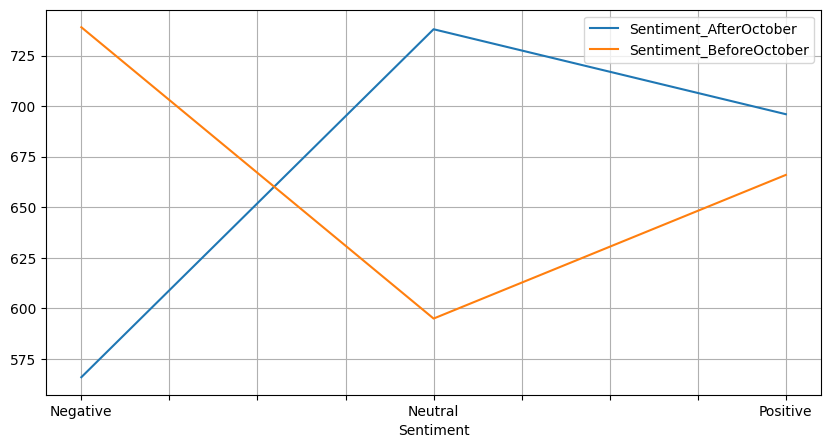

In [29]:
results.plot(x='Sentiment',y=['Sentiment_AfterOctober','Sentiment_BeforeOctober'],figsize=(10,5),grid=True)

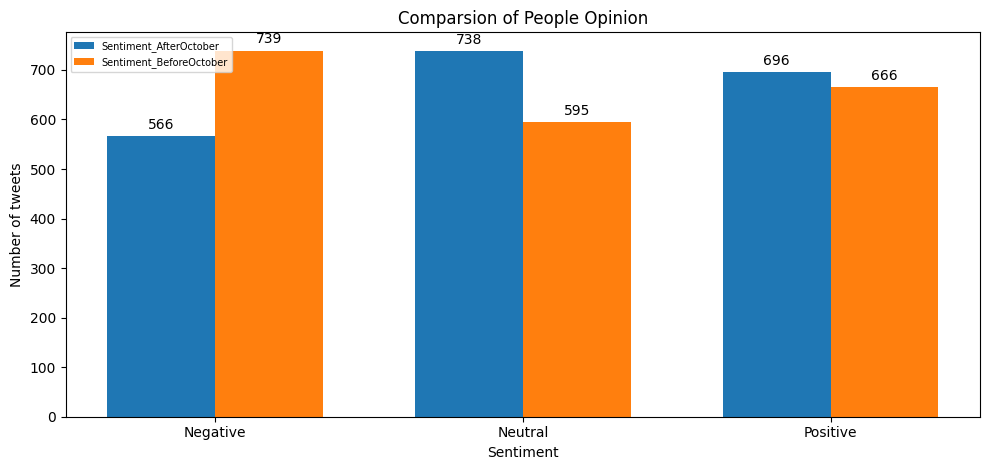

In [101]:
plt.rcParams["figure.figsize"] = (10,4.8)

#results.plot(x='Sentiment',y=['Sentiment_AfterOctober','Sentiment_BeforeOctober'],figsize=(10,5),grid=True)
fig, ax = plt.subplots()
labels=results['Sentiment']
x=np.arange(len(labels))
width=0.35
rects1 = ax.bar(x - width/2, results['Sentiment_AfterOctober'], width, label='Sentiment_AfterOctober')
rects2 = ax.bar(x + width/2, results['Sentiment_BeforeOctober'], width, label='Sentiment_BeforeOctober')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Sentiment')
ax.set_title('Comparsion of People Opinion')
ax.set_xticks(x,labels)
ax.legend(loc=2, prop={'size': 7})

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [49]:
results_youtubetwitter.columns

Index(['Sentiment', 'Twitter', 'Youtube'], dtype='object')

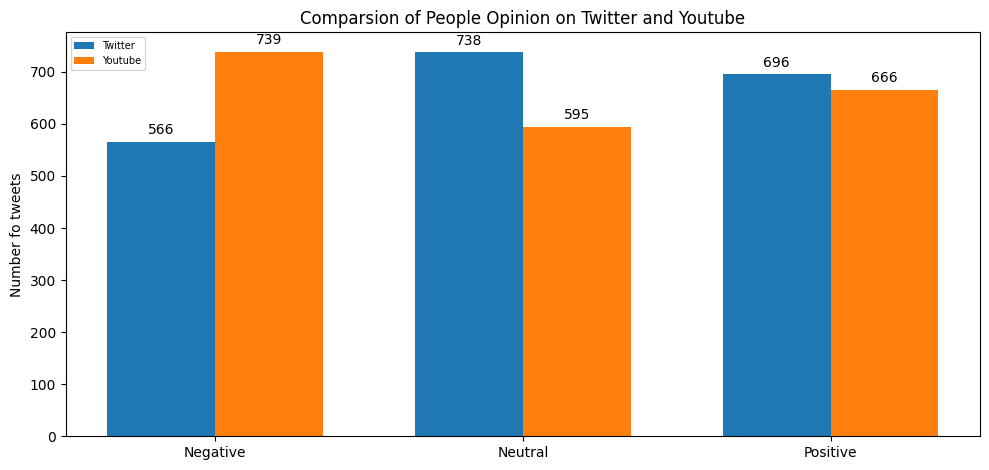

In [102]:
plt.rcParams["figure.figsize"] = (10,4.8)

#results.plot(x='Sentiment',y=['Sentiment_AfterOctober','Sentiment_BeforeOctober'],figsize=(10,5),grid=True)
fig, ax = plt.subplots()
labels=results_youtubetwitter['Sentiment']
x=np.arange(len(labels))
width=0.35
rects1 = ax.bar(x - width/2, results_youtubetwitter['Twitter'], width, label='Twitter')
rects2 = ax.bar(x + width/2, results_youtubetwitter['Youtube'], width, label='Youtube')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number fo tweets')
ax.set_title('Comparsion of People Opinion on Twitter and Youtube')
ax.set_xticks(x,labels)
ax.legend(loc=2, prop={'size': 7})

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Frequent Negative Words in Twitter and Youtube

In [70]:
# Frequent Negative Words in Twitter and Youtube

youtube_df['Prediction']=svm_pred_youtube


TypeError: list indices must be integers or slices, not str

In [103]:
twitter_pred=pd.DataFrame({'Clean_aOct':clean_data_afterOCt,'Predictions':svm_pred_afterOct})
twitter_pred_before=pd.DataFrame({'Clean_aOct':clean_data_beforeOCt,'Predictions':svm_pred_beforeOct})

In [77]:
twtiter_negative=twitter_pred[twitter_pred['Predictions']=='Negative']
twtiter_postitive=twitter_pred[twitter_pred['Predictions']=='Positive']

In [106]:
twtiter_negative_before=twitter_pred_before[twitter_pred_before['Predictions']=='Negative']
twtiter_postitive_before=twitter_pred_before[twitter_pred_before['Predictions']=='Positive']

In [81]:
youtube_negative=youtube_df[youtube_df['Prediction']=='Negative']
youtube_postitive=youtube_df[youtube_df['Prediction']=='Positive']

In [78]:
from collections import Counter
Counter(" ".join(twtiter_negative["Clean_aOct"]).split()).most_common(10)

[('semi', 343),
 ('event', 274),
 ('with', 268),
 ('delivery', 266),
 ('from', 264),
 ('after', 261),
 ('watch', 256),
 ('\u2066tesla', 252),
 ('iphone', 252),
 ('delicious', 252)]

In [82]:
youtube_df.columns

Index(['Unnamed: 0', 'comments', 'Prediction'], dtype='object')

In [ ]:
import string
def clean_text(text):
    text=text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'\b\w{1,3}\b', '',text)
    return text

In [84]:
youtubeclean=[]
for i in youtube_df["comments"]:
    youtubeclean.append(clean_text(i))

In [85]:
youtube_df['clean']=youtubeclean

In [86]:
Counter(" ".join(youtube_df["clean"]).split()).most_common(10)

[('that', 1344),
 ('tesla', 951),
 ('this', 891),
 ('’', 817),
 ('have', 790),
 ('with', 640),
 ('just', 633),
 ('like', 609),
 ('your', 590),
 ('model', 549)]

WorcCloud

In [88]:
stopwords = set(STOPWORDS)

In [94]:
def wordcloud_genera(col):
    
    comment_words = ''
    for val in col:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    return wordcloud


 


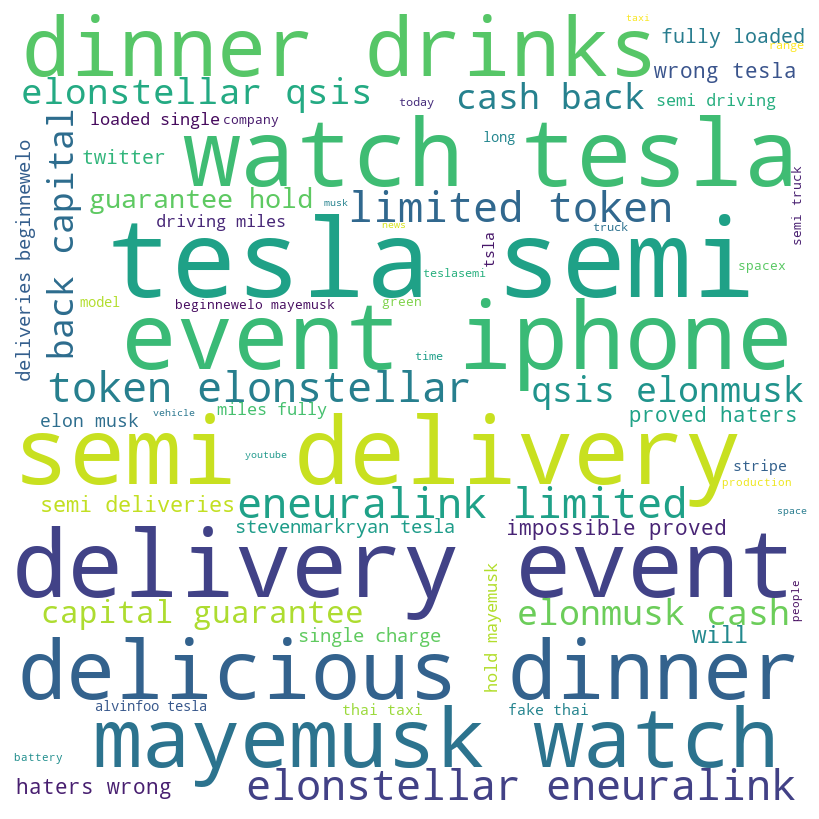

In [96]:
# plot the WordCloud image                      
clean_tw_ne=twtiter_negative['Clean_aOct']
Wordcloud=wordcloud_genera(clean_tw_ne)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(Wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

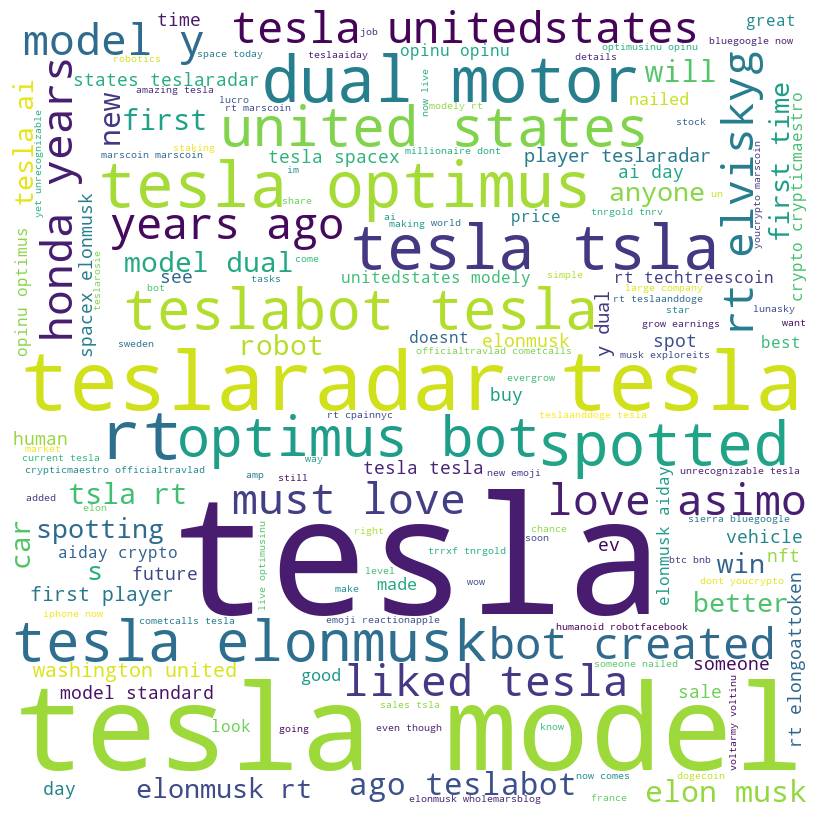

In [109]:
# plot the WordCloud image                      
clean_tw_ne=twtiter_postitive_before['Clean_aOct']
Wordcloud=wordcloud_genera(clean_tw_ne)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(Wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
param_dict_dt={
    'criterion':['gini','entropy'],
    'max_depth':range(1,5),
    'min_samples_split':range(1,5),
    'min_samples_leaf':range(1,5)
}

In [ ]:
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), param_dict_dt, verbose=1, cv=5)
grid_search_cv.fit(X_train, Y_train)